In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))

Warning message:
"package 'ggplot2' was built under R version 4.3.2"


In [2]:
plot_prefix <- 'plots/w06_'

### Visualizing Differences in $\alpha$ using Simple Exponential Smoothing

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`."


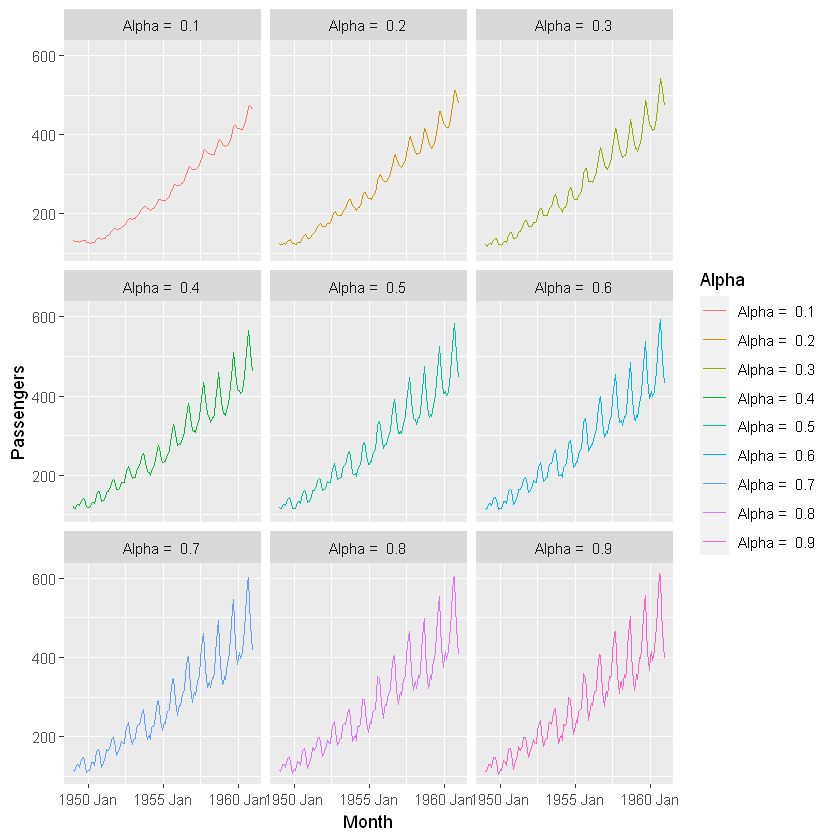

In [3]:
data(AirPassengers)
alphas <- seq(0.1, .9, by=0.1)
alpha_impact <- sapply(alphas, function(x) fitted(forecast::ses(AirPassengers, alpha = x)))

alpha_impact <- alpha_impact %>% 
as_tibble() %>% 
mutate(Month = yearmonth(seq(as.Date('1949-01-01'), as.Date('1960-12-01'),by='1 month'))) %>% as_tsibble(index='Month')

names(alpha_impact) <- c(paste('Alpha = ',alphas), 'Month')

alpha_impact <- alpha_impact %>% pivot_longer(!Month, names_to='Alpha', values_to='Passengers')

alpha_impact %>% ggplot(aes(x=Month, y=Passengers, colour=Alpha)) + geom_line() + facet_wrap(.~Alpha)

ggsave(paste(plot_prefix, 'airpassenger_ses_alpha.png', sep=''), height = 5, width = 6)

### Forecasts for Different Levels of $\alpha$ Using Simple Exponential Smoothing Models

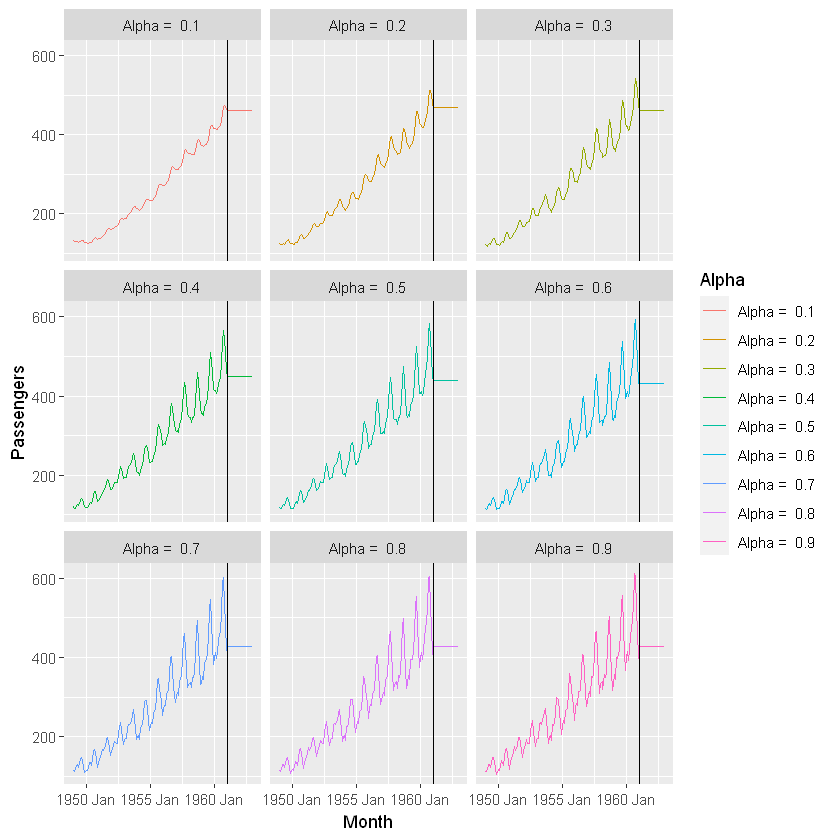

In [4]:
data(AirPassengers)
alphas <- seq(0.1, .9, by=0.1)
alpha_impact_forecasts <- sapply(alphas, function(x) forecast::ses(AirPassengers, alpha = x, h = 24)$mean)

alpha_impact_forecasts <- alpha_impact_forecasts %>% 
as_tibble() %>% 
mutate(Month = yearmonth(seq(as.Date('1961-01-01'), as.Date('1962-12-01'),by='1 month'))) %>% as_tsibble(index='Month')

names(alpha_impact_forecasts) <- c(paste('Alpha = ',alphas), 'Month')

alpha_impact_forecasts <- alpha_impact_forecasts %>% pivot_longer(!Month, names_to='Alpha', values_to='Passengers')
alpha_impact_forecasts <- bind_rows(alpha_impact, alpha_impact_forecasts)


alpha_impact_forecasts %>% ggplot(aes(x=Month, y=Passengers, colour=Alpha)) + geom_line() + geom_vline(xintercept = as.Date('1961-01-01')) + facet_wrap(.~Alpha)

ggsave(paste(plot_prefix, 'airpassenger_ses_alpha_forecasts.png', sep=''), height = 5, width = 6)

### Holt's Linear Trend

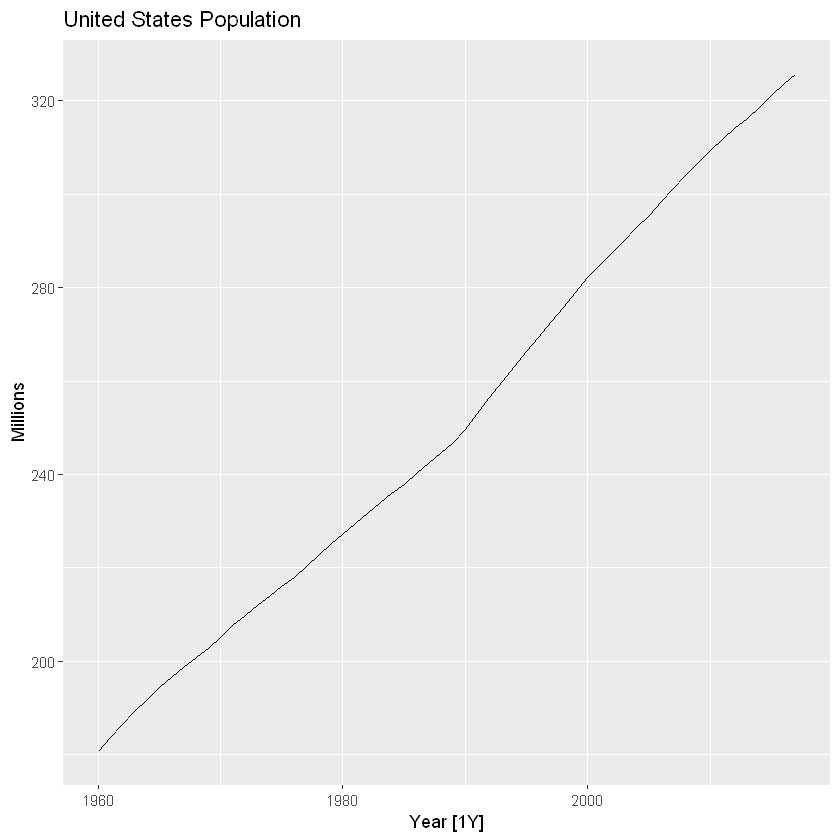

In [5]:
usa_economy <- global_economy |>
  filter(Code == "USA") |>
  mutate(Pop = Population / 1e6) 
  
usa_economy |> autoplot(Pop) + labs(y = "Millions", title = "United States Population")

In [6]:
fit <- usa_economy |>
  model(
    `Holt's Method` = ETS(Pop ~ error("A") + trend("A") + season("N")),
    `Holt's Damped` = ETS(Pop ~ error("A") + trend("Ad", phi=0.9) + season("N")),
  )

fit %>% select(.model = `Holt's Method`) %>% report()

Series: Pop 
Model: ETS(A,A,N) 
  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.999344 

  Initial states:
     l[0]     b[0]
 177.6493 3.022396

  sigma^2:  0.0344

     AIC     AICc      BIC 
45.87163 47.02547 56.17384 


In [7]:
fit %>% select(.model = `Holt's Damped`) %>% report()

Series: Pop 
Model: ETS(A,Ad,N) 
  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.9998996 
    phi   = 0.9 

  Initial states:
     l[0]     b[0]
 177.2855 3.731325

  sigma^2:  0.095

     AIC     AICc      BIC 
103.7272 104.8810 114.0294 


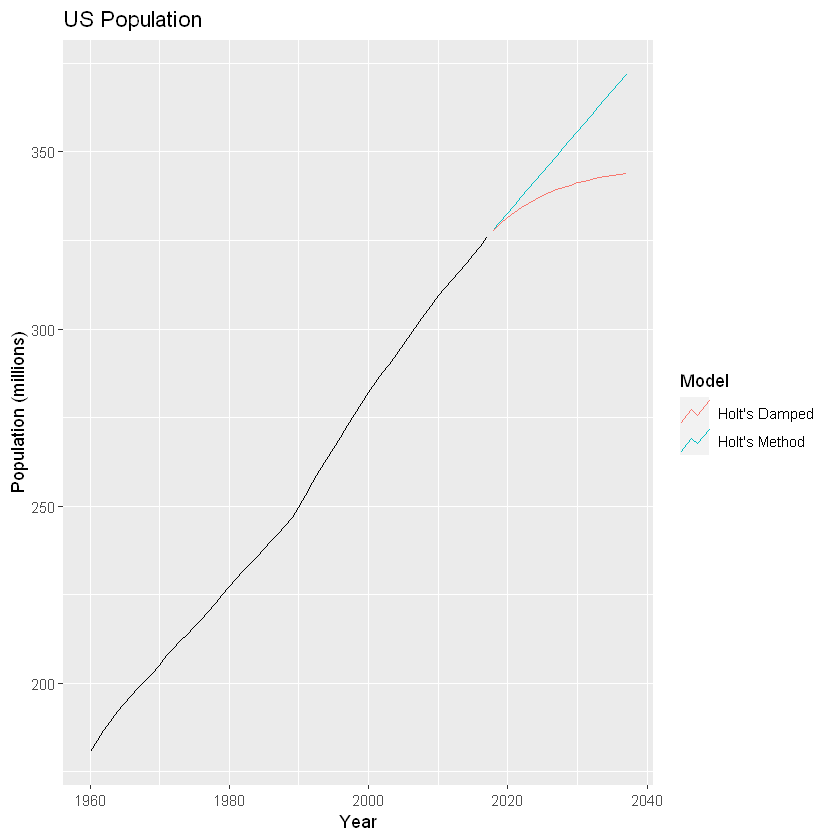

In [8]:
fit |>
forecast(h=20) |>
autoplot(usa_economy, level=NULL) +
labs(title='US Population', y='Population (millions)') +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix, '_usa_forecast.png', sep=''), height=3, width = 5)

### Holt-Winter's

In [9]:
data(AirPassengers)
ap <- AirPassengers %>% as_tsibble()
names(ap) <- c('Month', 'Passengers')

ap_training <- ap %>% filter_index(. ~ "1958 Dec")
ap_test <- ap %>% filter_index("1959 Jan" ~ .)

ap_fit <- ap_training |>
model(
    `SES` = ETS(Passengers ~ error("A") + trend("N") + season("N")),
    `Holt Linear`= ETS(Passengers ~ error("A") + trend("A") + season("N")),
    `Holt Damped`= ETS(Passengers ~ error("A") + trend("Ad") + season("N")),
    `Holt Linear Additive`= ETS(Passengers ~ error("A") + trend("A") + season("A")),
    `Holt Linear Mult.`= ETS(Passengers ~ error("M") + trend("A") + season("M")),
    `Holt Damped Additive`= ETS(Passengers ~ error("A") + trend("Ad") + season("A")),
    `Holt Damped Mult.`= ETS(Passengers ~ error("M") + trend("Ad") + season("M")),    
)

ap_fit %>% report()

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,sigma2,log_lik,AIC,AICc,BIC,MSE,AMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SES,8.318360e+02,-689.6592,1385.318,1385.525,1393.681,817.97207,2061.4686,21.97697294
Holt Linear,8.435232e+02,-689.4707,1388.941,1389.468,1402.879,815.40574,2046.3196,21.93980112
Holt Damped,8.518872e+02,-689.5432,1391.086,1391.830,1407.811,816.39194,2051.3026,22.01057654
Holt Linear Additive,2.262314e+02,-603.9570,1241.914,1247.914,1289.301,196.06721,461.4611,10.43029665
Holt Linear Mult.,1.680884e-03,-546.7671,1127.534,1133.534,1174.922,100.61104,144.2068,0.02963331
Holt Damped Additive,2.303277e+02,-604.4539,1244.908,1251.680,1295.083,197.69791,468.7196,10.42096520
Holt Damped Mult.,1.455268e-03,-537.2249,1110.450,1117.222,1160.625,79.17853,150.8217,0.02788724


Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."


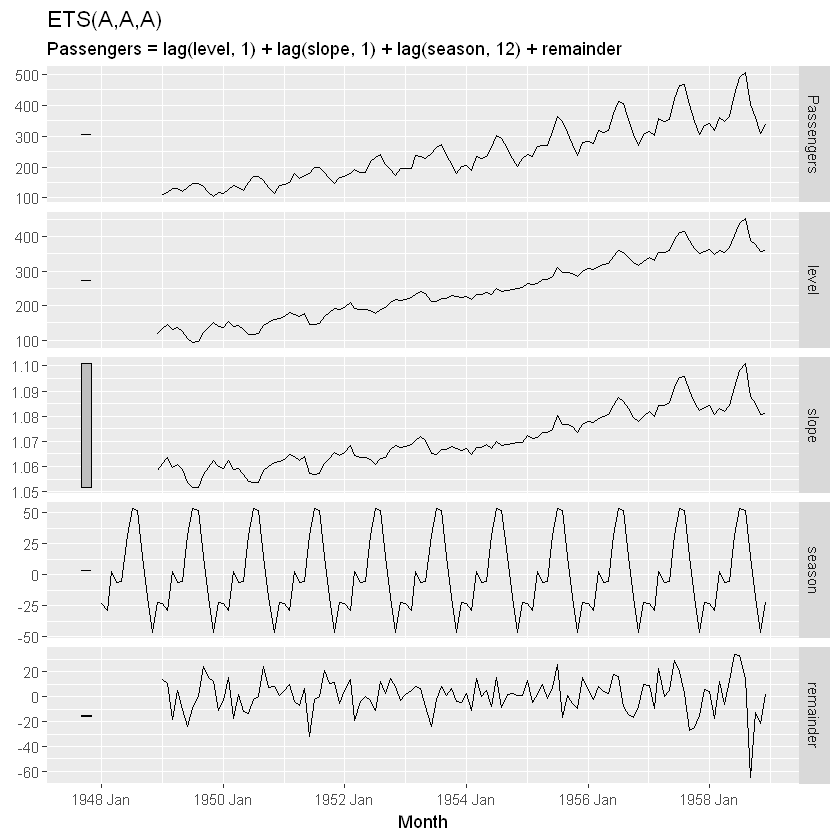

In [10]:
# Additive Decomposition
components(ap_fit) %>% filter(.model == 'Holt Linear Additive') %>% autoplot() +
labs(title='ETS(A,A,A)')

ggsave(paste(plot_prefix, 'ap_linear_additive_components.png'), height = 4, width = 4)

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."


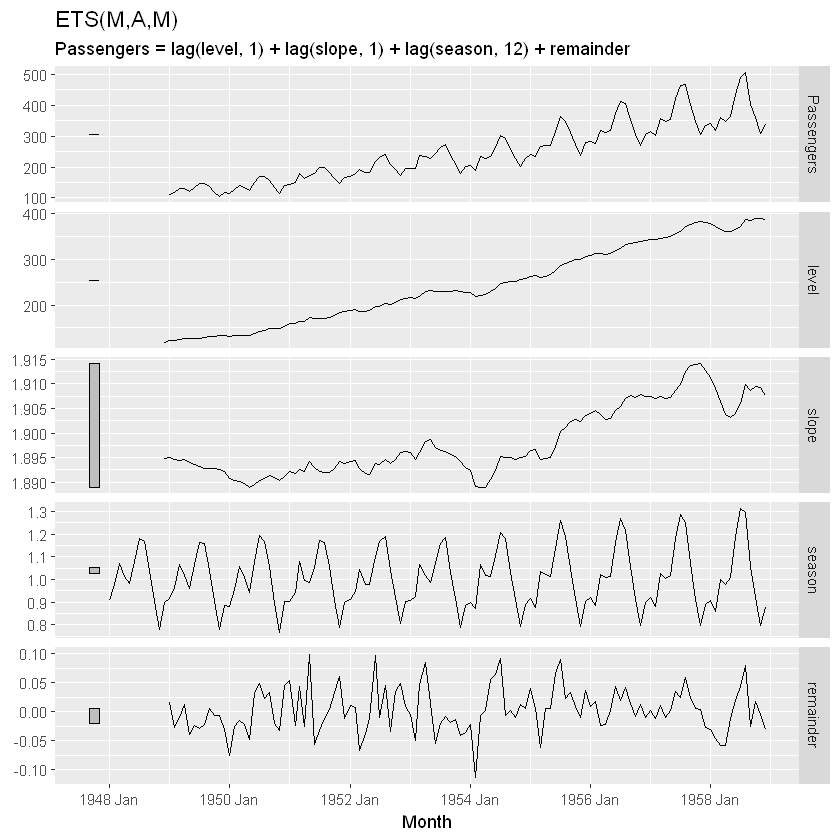

In [12]:
# Multiplicative Decomposition
components(ap_fit) %>% filter(.model == 'Holt Linear Mult.') %>% autoplot() +
labs(title='ETS(M,A,M)')

ggsave(paste(plot_prefix, 'ap_linear_mult_components.png'), height = 4, width = 4)

In [13]:
ap_fit %>% accuracy() %>% select(.model, ACF1)

.model,ACF1
<chr>,<dbl>
SES,0.2834787
Holt Linear,0.2828367
Holt Damped,0.2828339
Holt Linear Additive,0.1721457
Holt Linear Mult.,0.3653906
Holt Damped Additive,0.1748261
Holt Damped Mult.,0.1188263


In [14]:
ap_fit_forecast <- ap_fit %>% forecast(h=24)

In [15]:
ap_fit_forecast %>% accuracy(ap_test) %>% select(.model, ACF1)

.model,ACF1
<chr>,<dbl>
Holt Damped,0.7265581
Holt Damped Additive,0.7450945
Holt Damped Mult.,0.7463877
Holt Linear,0.7077133
Holt Linear Additive,0.7197066
Holt Linear Mult.,0.5662711
SES,0.7282432


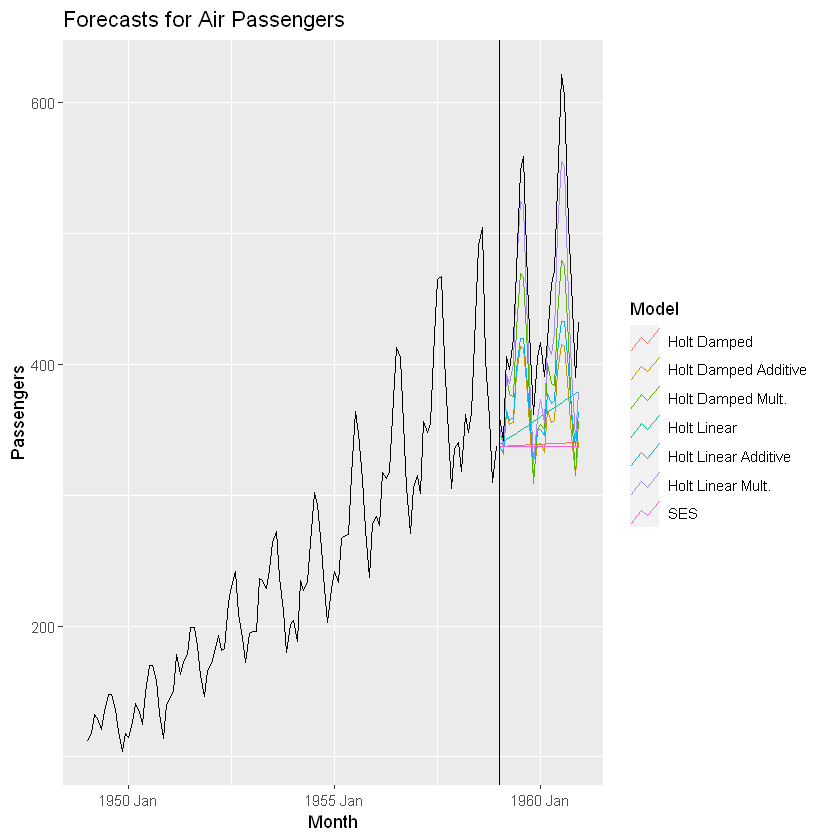

In [16]:
ap_fit_forecast %>% autoplot(ap_training, level=NULL) + autolayer(ap_test, Passengers) +
labs(title='Forecasts for Air Passengers') +
geom_vline(xintercept = as.Date('1959-01-01')) +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix, '_ap_exponential_smoothing_forecasts.png', sep=''), height=3, width=5)

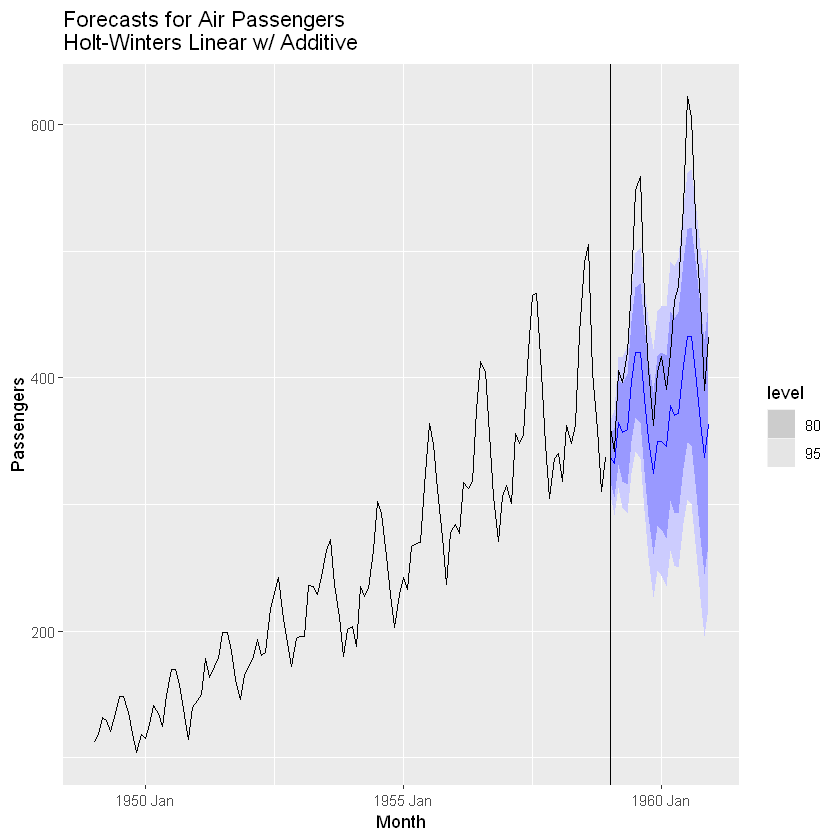

In [17]:
# Additive
ap_fit_forecast %>% filter(.model == "Holt Linear Additive") |>
 autoplot(ap_training) + autolayer(ap_test, Passengers) +
labs(title='Forecasts for Air Passengers\nHolt-Winters Linear w/ Additive') +
geom_vline(xintercept = as.Date('1959-01-01')) +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix, '_ap_exponential_smoothing_forecasts_additive.png', sep=''), height=4, width=4)

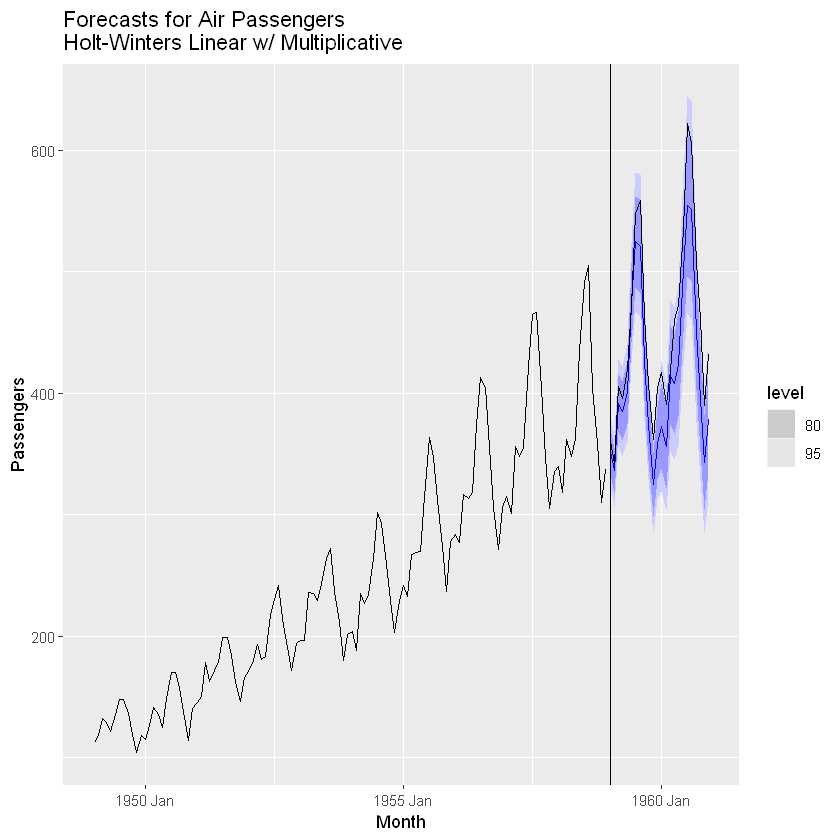

In [18]:
# Multiplicative, Best Performer
ap_fit_forecast %>% filter(.model == "Holt Linear Mult.") |>
 autoplot(ap_training) + autolayer(ap_test, Passengers) +
labs(title='Forecasts for Air Passengers\nHolt-Winters Linear w/ Multiplicative') +
geom_vline(xintercept = as.Date('1959-01-01')) +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix, '_ap_exponential_smoothing_forecasts_champ.png', sep=''), height=4, width=4)

### State Space Example

In [19]:
h02 <- PBS %>%
filter(ATC2 == "H02") %>% arrange(Month)

h02 %>% head(10)

Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
<mth>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1991 Jul,Concessional,Co-payments,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,63261,317384
1991 Jul,Concessional,Safety net,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,12211,82929
1991 Jul,General,Co-payments,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,4013,20178
1991 Jul,General,Safety net,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,2101,9304
1991 Aug,Concessional,Co-payments,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,53528,269891
1991 Aug,Concessional,Safety net,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,14827,100602
1991 Aug,General,Co-payments,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,3397,16519
1991 Aug,General,Safety net,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,2970,13894
1991 Sep,Concessional,Co-payments,H,"Systemic hormonal preparations, excl. sex hormones and insulins",H02,CORTICOSTEROIDS FOR SYSTEMIC USE,52822,269703


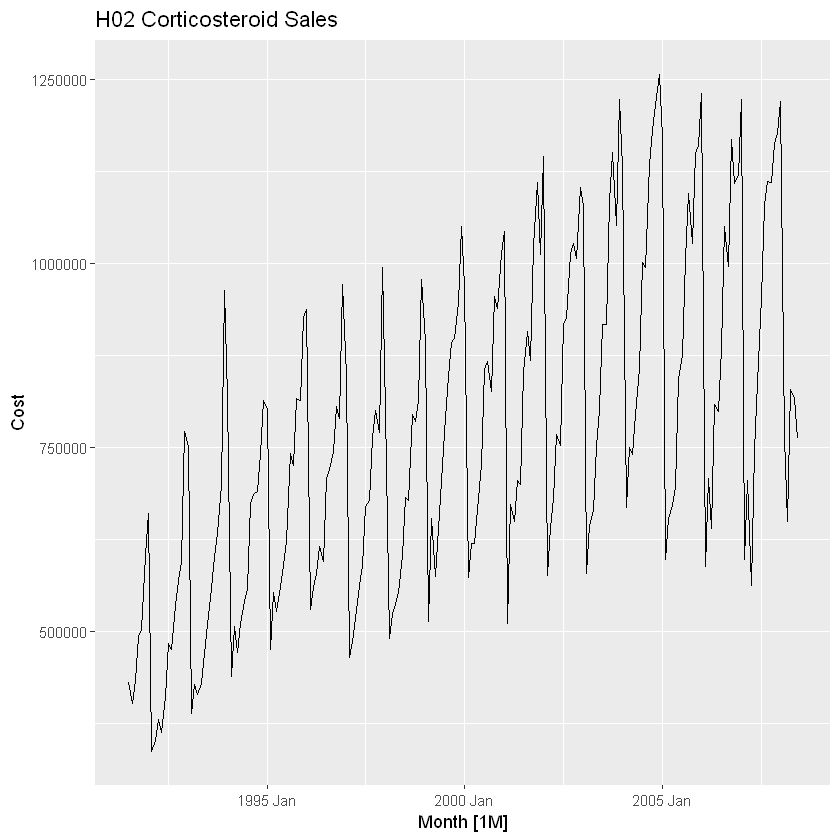

In [20]:
h02_agg <- h02 %>%
summarise(Cost = sum(Cost))

h02_agg %>% autoplot(Cost) + labs(title='H02 Corticosteroid Sales')

ggsave(paste(plot_prefix, '_drug_sales.png'), height=3, width = 5)

In [21]:
h02_agg %>% has_gaps()

.gaps
<lgl>
FALSE


In [ ]:
h02_agg

In [22]:
h02_training <- h02_agg %>% filter_index(.~'2006 Dec')
h02_test <- h02_agg %>% filter_index('2007 Jan'~.)

In [23]:
h02_fit <- h02_training %>%
model(
    `Auto` = ETS(Cost),
    `AAA`  = ETS(Cost ~ error('A') + trend('A') + season('A')),
    `MAM`  = ETS(Cost ~ error('M') + trend('A') + season('M'))  
    )

h02_fit %>% report() %>% select(.model, AIC, AICc, BIC)

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,AIC,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>
Auto,4979.422,4983.518,5037.485
AAA,5057.470,5061.113,5112.308
MAM,4984.124,4987.766,5038.961


In [24]:
h02_fit %>% select(Auto) %>% report()

Series: Cost 
Model: ETS(M,Ad,M) 
  Smoothing parameters:
    alpha = 0.3439161 
    beta  = 0.0001009072 
    gamma = 0.0001011135 
    phi   = 0.9794966 

  Initial states:
     l[0]    b[0]      s[0]     s[-1]     s[-2]     s[-3]     s[-4]    s[-5]
 418404.5 8156.54 0.8696543 0.8240501 0.7655235 0.7770682 0.6920356 1.284844
    s[-6]    s[-7]    s[-8]   s[-9]   s[-10]    s[-11]
 1.341229 1.177702 1.157124 1.09754 1.034299 0.9789306

  sigma^2:  0.004

     AIC     AICc      BIC 
4979.422 4983.518 5037.485 


In [25]:
h02_fit %>% select(MAM) %>% report()

Series: Cost 
Model: ETS(M,A,M) 
  Smoothing parameters:
    alpha = 0.2354421 
    beta  = 0.004883047 
    gamma = 0.3743197 

  Initial states:
   l[0]     b[0]     s[0]     s[-1]     s[-2]     s[-3]     s[-4]    s[-5]
 446300 6508.387 0.848147 0.7914146 0.7916234 0.7925736 0.7309035 1.402094
    s[-6]    s[-7]    s[-8]    s[-9]    s[-10]    s[-11]
 1.414464 1.138205 1.099471 1.034382 0.9793556 0.9773659

  sigma^2:  0.004

     AIC     AICc      BIC 
4984.124 4987.766 5038.961 


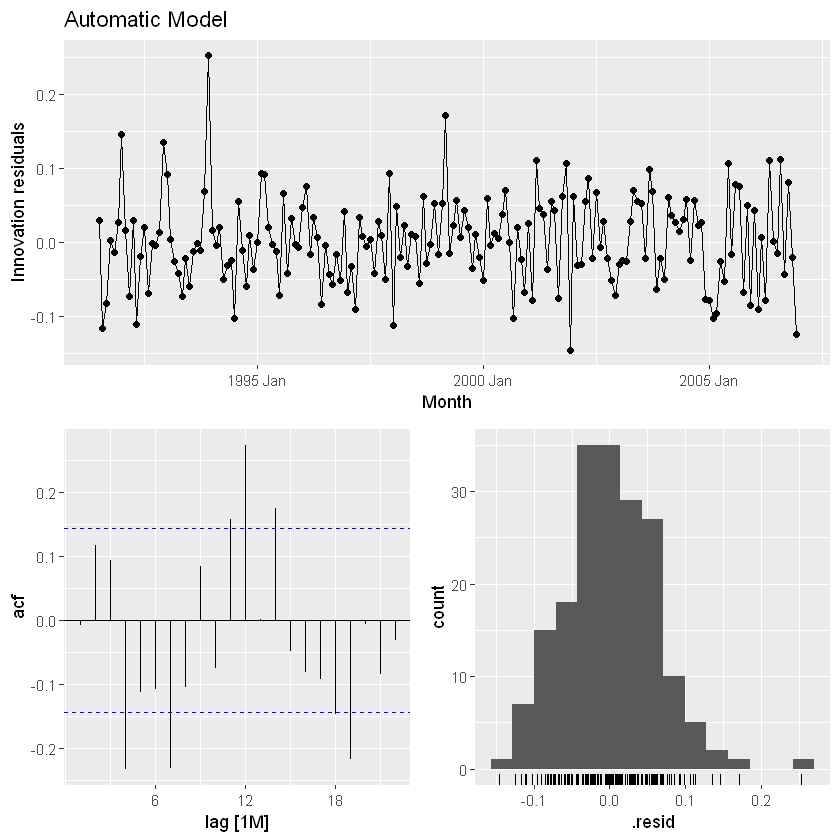

In [26]:
auto_resid <- h02_fit %>% select(Auto) %>% gg_tsresiduals() + labs(title='Automatic Model')
auto_resid
ggsave(paste(plot_prefix,'_drug_auto_resid.png'),plot=auto_resid, height = 4, width = 4)

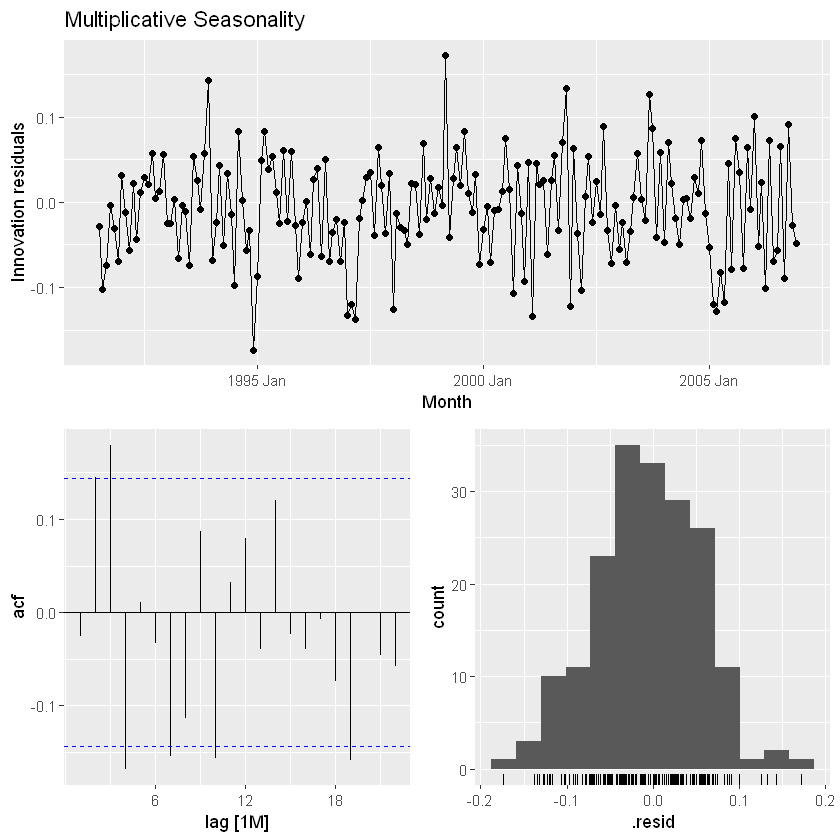

In [27]:
mam_fit <- h02_fit %>% select(MAM) %>% gg_tsresiduals() + labs(title='Multiplicative Seasonality')
mam_fit
ggsave(paste(plot_prefix,'_drug_mam_resid.png'), plot=mam_fit, height = 4, width = 4)

In [28]:
h02_forecast <- h02_fit %>% forecast(h02_test)
h02_forecast %>% accuracy(h02_test) %>% select(.model, RMSE, ACF1)

.model,RMSE,ACF1
<chr>,<dbl>,<dbl>
AAA,77548.62,-0.13642336
Auto,79347.85,0.05985516
MAM,68223.15,-0.12628956


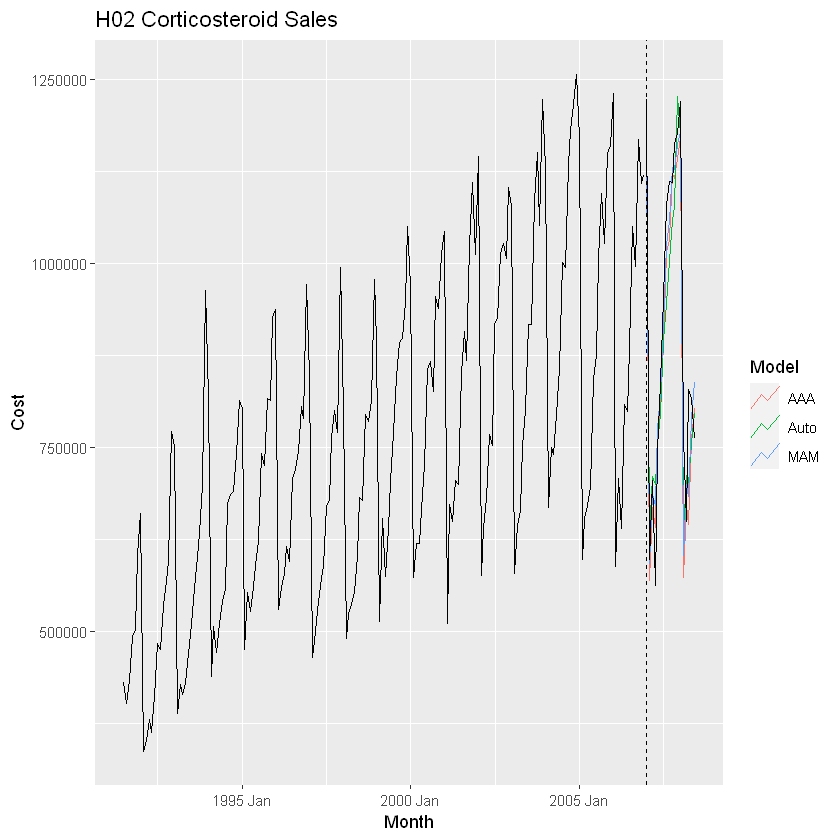

In [29]:
h02_forecast %>% autoplot(h02_training, level=NULL) +
autolayer(h02_test, Cost) +
geom_vline(xintercept = as.Date('2007-01-01'), linetype='dashed') +
labs(title='H02 Corticosteroid Sales') +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix, '_drug_forecasts.png', sep=''), height = 4, width = 6)

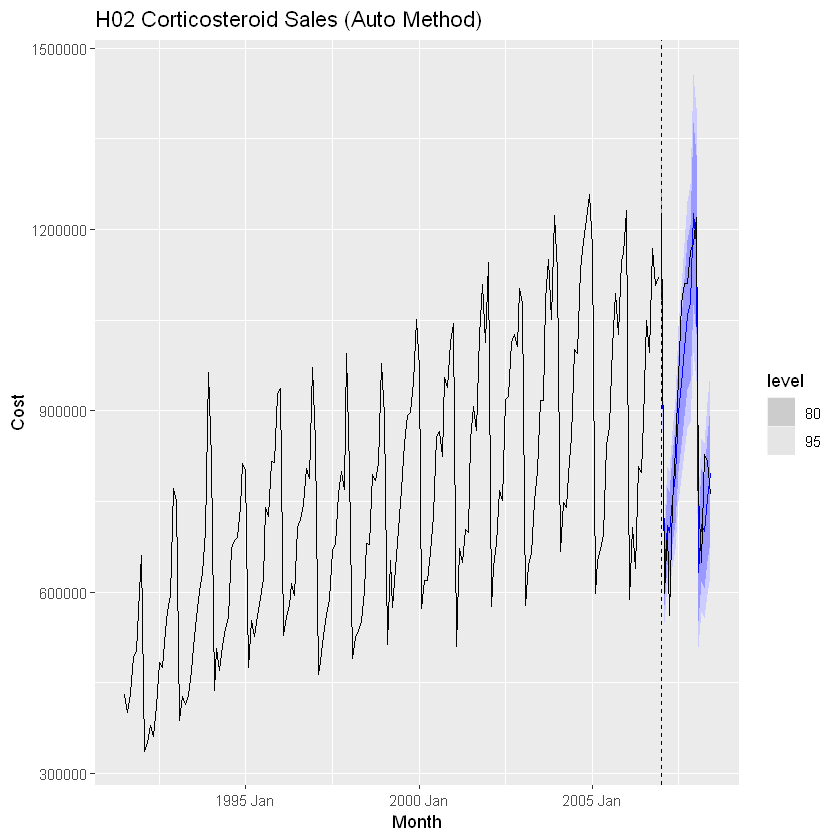

In [30]:
h02_forecast %>% filter(.model == 'Auto') %>%
autoplot(h02_training) +
autolayer(h02_test, Cost) +
geom_vline(xintercept = as.Date('2007-01-01'), linetype='dashed') +
labs(title='H02 Corticosteroid Sales (Auto Method)') +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix,'_drug_auto_pi.png'), height = 3, width = 5)

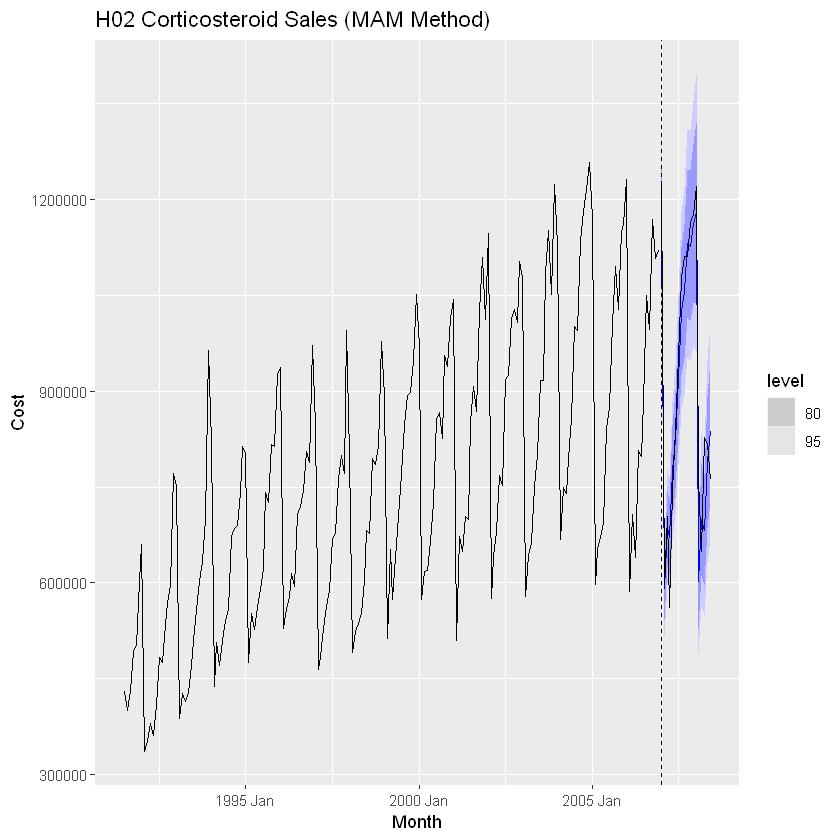

In [31]:
h02_forecast %>% filter(.model == 'MAM') %>%
autoplot(h02_training) +
autolayer(h02_test, Cost) +
geom_vline(xintercept = as.Date('2007-01-01'), linetype='dashed') +
labs(title='H02 Corticosteroid Sales (MAM Method)') +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix,'_drug_mam_pi.png'), height = 3, width = 5)

### Exponential Smoothing vs. Seasonal Trend vs. Scenario Analysis vs. Naive Models
Forecasting the 10-year treasury yield.

In [32]:
gs10 <- read.csv('data/gs10.csv')

gs10 <- gs10 %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
rename(TEN_YEAR_YIELD = GS10) %>%
as_tsibble(index=DATE)

gs10 %>% head()

DATE,TEN_YEAR_YIELD
<mth>,<dbl>
1953 Apr,2.83
1953 May,3.05
1953 Jun,3.11
1953 Jul,2.93
1953 Aug,2.95
1953 Sep,2.87


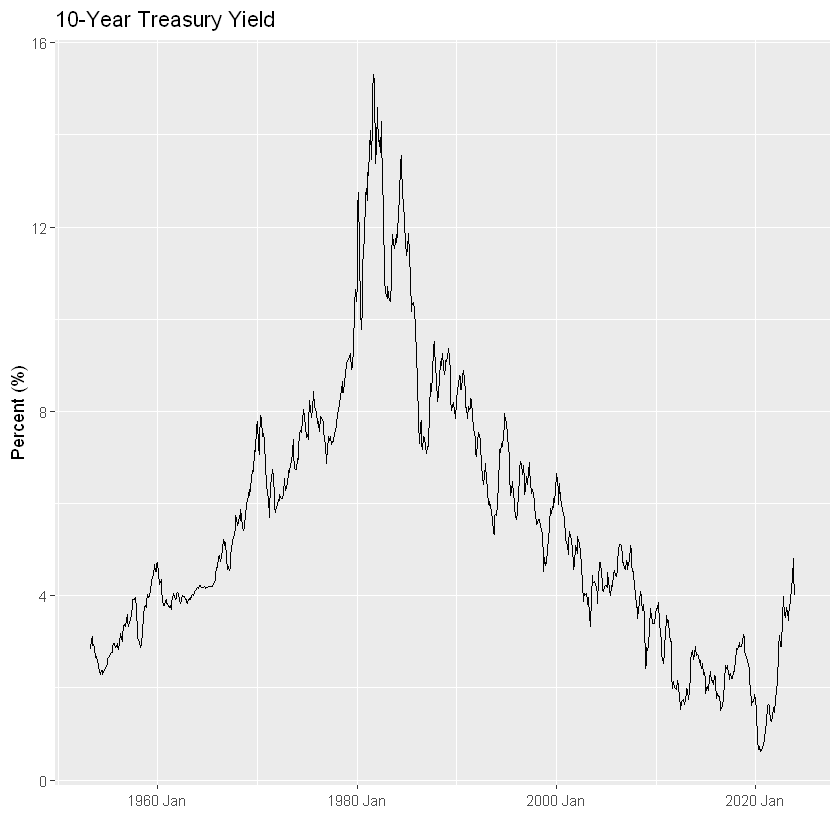

In [33]:
gs10 %>% autoplot(TEN_YEAR_YIELD) + labs(title='10-Year Treasury Yield', y='Percent (%)', x='')
ggsave(paste(plot_prefix,'_10yr.png'), height = 3, width = 5)

In [34]:
gs10[gs10$TEN_YEAR_YIELD == max(gs10$TEN_YEAR_YIELD), ]

DATE,TEN_YEAR_YIELD
<mth>,<dbl>
1981 Sep,15.32


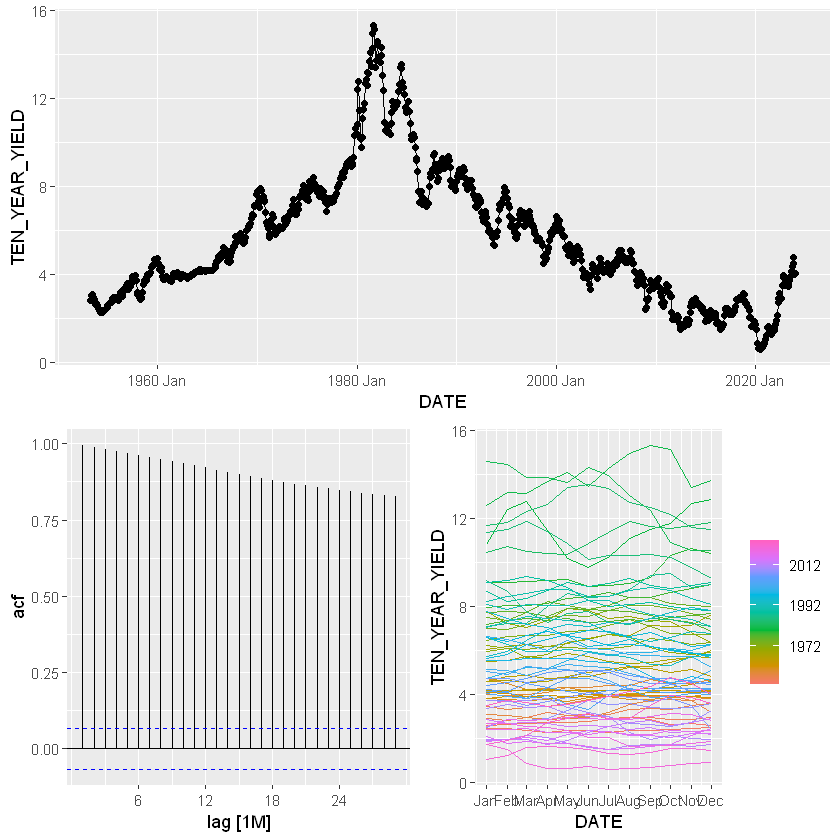

In [35]:
gs10 %>% gg_tsdisplay(TEN_YEAR_YIELD)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


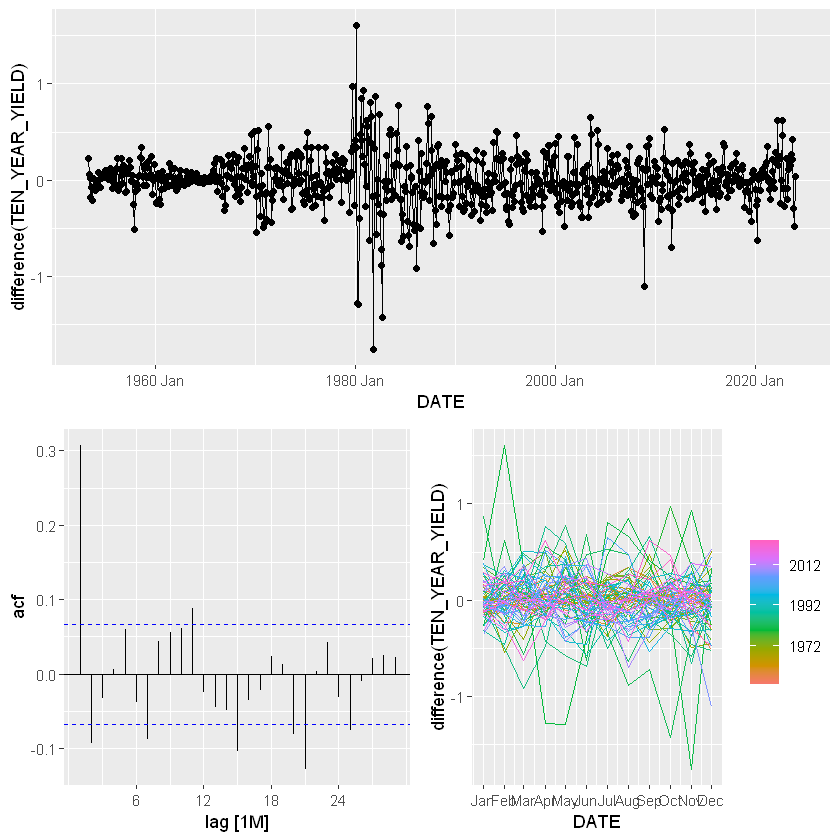

In [36]:
gs10 %>% gg_tsdisplay(difference(TEN_YEAR_YIELD))

In [37]:
ff <- read.csv('data/dff.csv')

ff <- ff %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
rename(EFF_FED_FUNDS = DFF) %>%
as_tsibble(index=DATE)

ff %>% head()

DATE,EFF_FED_FUNDS
<mth>,<dbl>
1954 Jul,0.7993548
1954 Aug,1.2206452
1954 Sep,1.0666667
1954 Oct,0.8487097
1954 Nov,0.8336667
1954 Dec,1.2777419


In [40]:
ff_adj <- read.csv('data/ff_projections.csv')

ff_adj <- ff_adj %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
as_tsibble(index=DATE)

ff_adj %>% head()

DATE,PROJECTION
<mth>,<dbl>
2023 Feb,4.33
2023 Mar,4.43
2023 Apr,4.53
2023 May,4.63
2023 Jun,4.73
2023 Jul,4.83


In [ ]:
ff %>% autoplot(EFF_FED_FUNDS) + labs(title='Effective Federal Funds Rate', y='Percent (%)', x='') +
autolayer(ff_adj, PROJECTION, color='red') +
geom_vline(xintercept = as.Date('2023-02-01'))

Replace the actual values in the Fed Funds in the test window with projections as of Jan 2023.

In [41]:
yield_ts <- gs10 %>%
left_join(ff, by='DATE') %>%
left_join(ff_adj, by='DATE') %>%
mutate(FED_FUND_ADJ = ifelse(!is.na(PROJECTION), PROJECTION, EFF_FED_FUNDS)) %>%
filter(!is.na(FED_FUND_ADJ)) %>%
select(-EFF_FED_FUNDS, -PROJECTION) %>%
as_tsibble()

yield_ts %>% head()

DATE,TEN_YEAR_YIELD,FED_FUND_ADJ
<mth>,<dbl>,<dbl>
1954 Jul,2.30,0.7993548
1954 Aug,2.36,1.2206452
1954 Sep,2.38,1.0666667
1954 Oct,2.43,0.8487097
1954 Nov,2.48,0.8336667
1954 Dec,2.51,1.2777419


#### Split into Training and Test

In [42]:
yield_training <- yield_ts %>% filter_index(. ~ '2023 Jan')
yield_test <- yield_ts %>% filter_index('2023 Feb' ~ .)

#### Fit Models

In [43]:
yield_models <- yield_training %>%
model(
    'Random Walk with Drift' = RW(TEN_YEAR_YIELD ~ drift()),
    'Regression with Splines' = TSLM(TEN_YEAR_YIELD ~ FED_FUND_ADJ + trend(knots = c(as.Date('1981-09-01'), as.Date('2020-03-01'), as.Date('2022-03-01')))),
    'ETS' = ETS(TEN_YEAR_YIELD)
)

yield_models

Random Walk with Drift,Regression with Splines,ETS
<model>,<model>,<model>
<RW w/ drift>,<TSLM>,"<ETS(A,Ad,N)>"


In [44]:
yield_models %>% report() %>% select(.model, AICc)

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,AICc
<chr>,<dbl>
Random Walk with Drift,NA
Regression with Splines,314.6507
ETS,3340.1334


Plot variable not specified, automatically selected `.vars = .fitted`
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


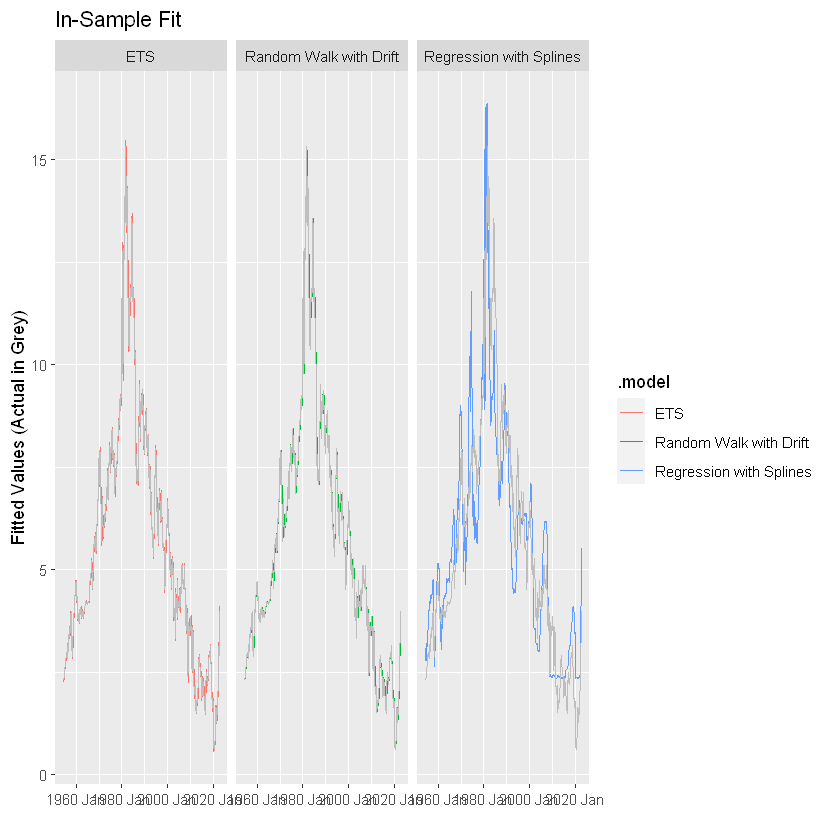

In [45]:
yield_models %>% fitted() %>%
autoplot() + 
autolayer(yield_training, TEN_YEAR_YIELD, col='grey') +
facet_grid(. ~ .model) +
labs(title='In-Sample Fit', y='Fitted Values (Actual in Grey)', x='')

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."


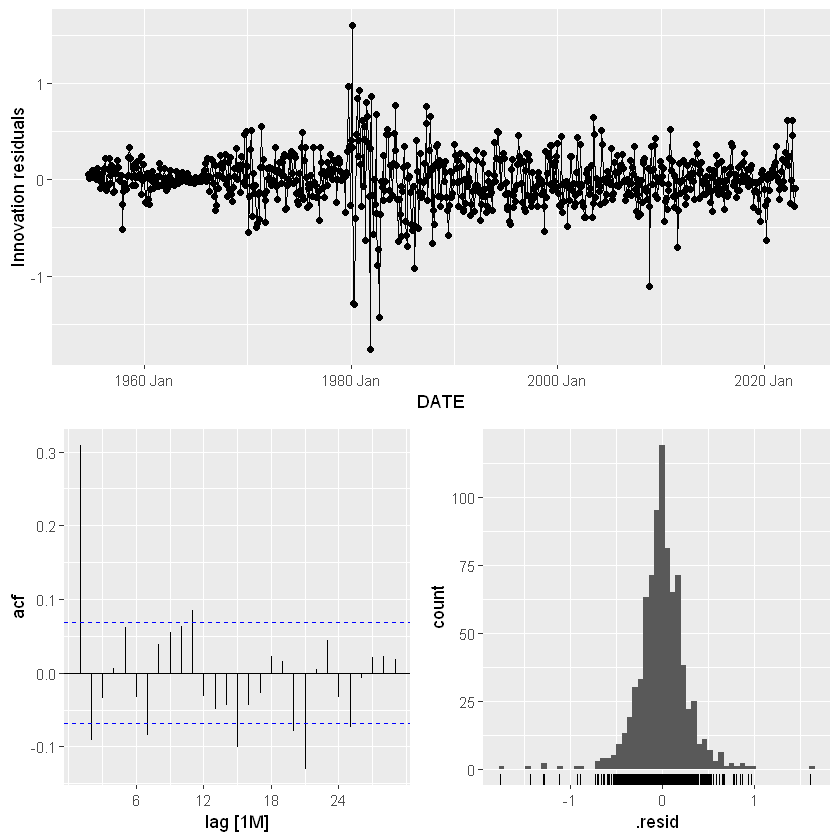

In [46]:
# Insert residual analysis
yield_models %>% select('Random Walk with Drift') %>% gg_tsresiduals()

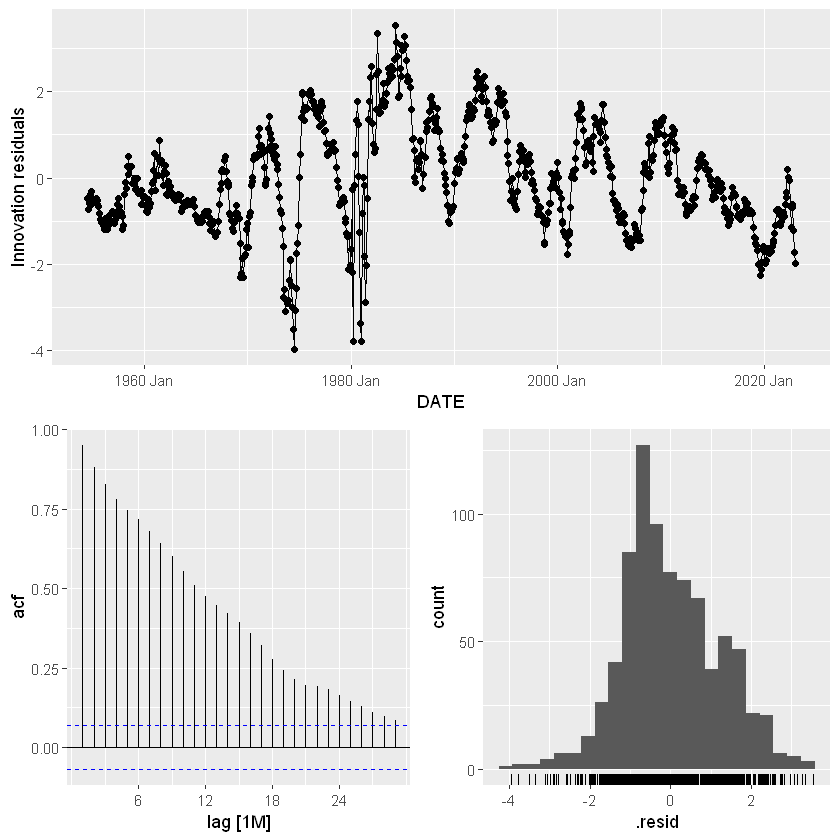

In [47]:
yield_models %>% select('Regression with Splines') %>% gg_tsresiduals()

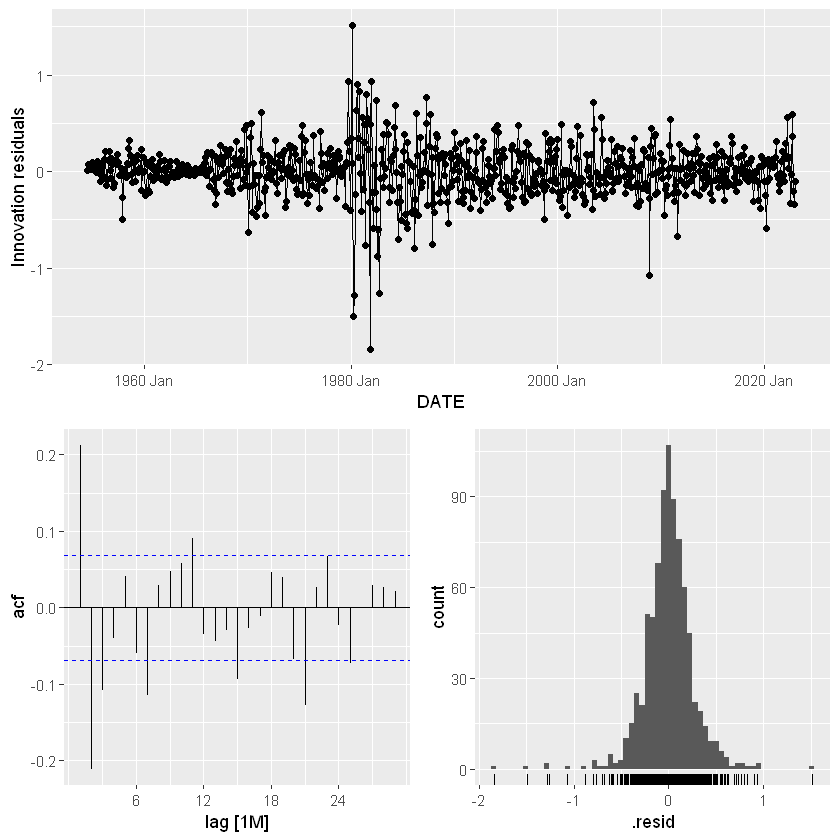

In [48]:
yield_models %>% select('ETS') %>% gg_tsresiduals()

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Regression with Splines = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading"


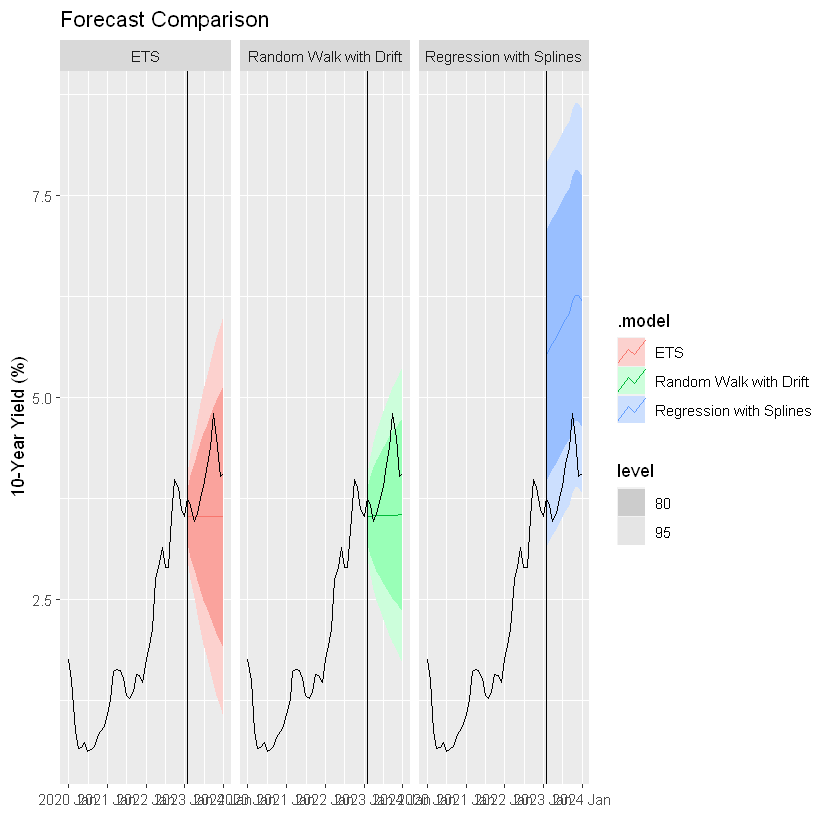

In [49]:
yield_models %>% 
forecast(yield_test) %>%
autoplot() +
facet_wrap(. ~ .model) +
autolayer(yield_ts %>% filter_index('2020 Jan' ~ .), TEN_YEAR_YIELD) +
labs(title='Forecast Comparison', y='10-Year Yield (%)', x='') +
geom_vline(xintercept = as.Date('2023-02-01'))

In [50]:
# Insert forecast comparison
yield_models %>% forecast(yield_test) %>% accuracy(yield_test) %>%
select(.model, ACF1, RMSE)

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Regression with Splines = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading"


.model,ACF1,RMSE
<chr>,<dbl>,<dbl>
ETS,0.7785836,0.6149435
Random Walk with Drift,0.7753591,0.6001441
Regression with Splines,0.5241682,1.9356327
